In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
using Zygote, Lux, LuxCUDA, ComponentArrays, Plots, QuadGK, Interpolations, Optimisers, NNlib, JLD2
using Random: Xoshiro
using MLUtils: DataLoader

In [3]:
using PhasorNetworks

# Load the dataset

In [4]:
include("pixel_data.jl")

interpolate_roc (generic function with 1 method)

In [5]:
using Base: @kwdef

In [6]:
@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 128    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
end

Args

In [7]:
args = Args(batchsize = 128)

Args(0.0003, 128, 10, false)

In [8]:
data_dir = "pixel_data/"

"pixel_data/"

In [9]:
file_pairs = get_dataset(data_dir)

10-element Vector{Tuple{String, String}}:
 ("pixel_data/labels/labels_d17301.parquet", "pixel_data/recon3D/recon3D_d17301.parquet")
 ("pixel_data/labels/labels_d17302.parquet", "pixel_data/recon3D/recon3D_d17302.parquet")
 ("pixel_data/labels/labels_d17303.parquet", "pixel_data/recon3D/recon3D_d17303.parquet")
 ("pixel_data/labels/labels_d17304.parquet", "pixel_data/recon3D/recon3D_d17304.parquet")
 ("pixel_data/labels/labels_d17305.parquet", "pixel_data/recon3D/recon3D_d17305.parquet")
 ("pixel_data/labels/labels_d17306.parquet", "pixel_data/recon3D/recon3D_d17306.parquet")
 ("pixel_data/labels/labels_d17307.parquet", "pixel_data/recon3D/recon3D_d17307.parquet")
 ("pixel_data/labels/labels_d17308.parquet", "pixel_data/recon3D/recon3D_d17308.parquet")
 ("pixel_data/labels/labels_d17309.parquet", "pixel_data/recon3D/recon3D_d17309.parquet")
 ("pixel_data/labels/labels_d17310.parquet", "pixel_data/recon3D/recon3D_d17310.parquet")

In [10]:
q, ylocal, pt = get_samples(file_pairs[1:2])

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [11]:
q_test, ylocal_test, pt_test = get_samples(file_pairs[3:3]);

In [12]:
q |> size

(20, 13, 21, 99991)

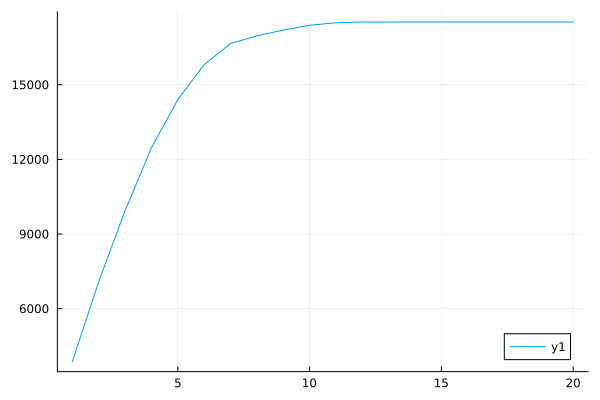

In [13]:
plot(sum(q[:,:,:,128], dims=(2,3)) |> vec)

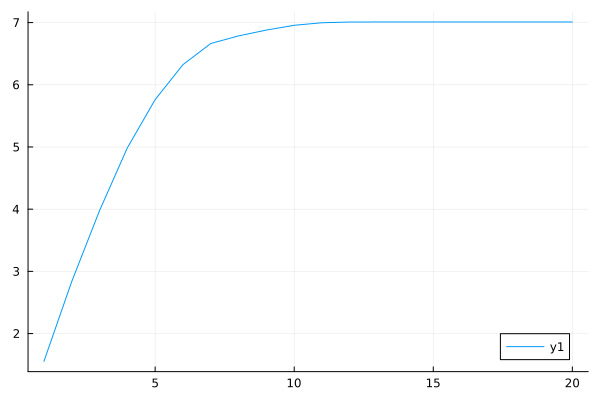

In [14]:
plot(sum(scale_charge(q[:,:,:,128]), dims=(2,3)) |> vec)

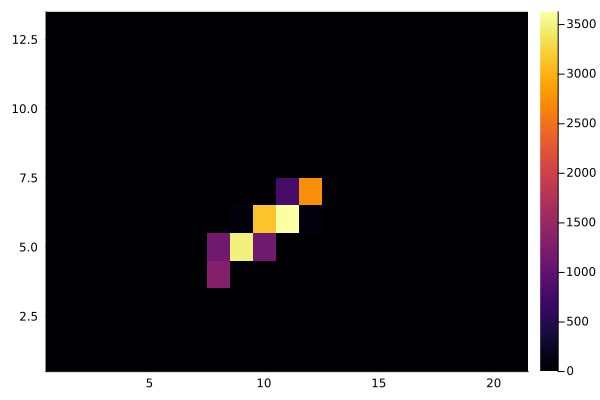

In [15]:
heatmap(q[12,:,:,128])

In [16]:
ylocal |> size

(99991,)

In [17]:
pt |> size

(99991,)

In [18]:
train_loader = DataLoader((q, ylocal, pt), batchsize=args.batchsize)

782-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}, Vector{Float64}}, batchsize=128)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64}, 128-element Vector{Float64},)

In [19]:
test_loader = DataLoader((q_test, ylocal_test, pt_test), batchsize=args.batchsize)

391-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}, Vector{Float64}}, batchsize=128)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64}, 128-element Vector{Float64},)

In [20]:
x, xl, y = first(train_loader)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [21]:
x |> size

(20, 13, 21, 128)

In [22]:
n_px = size(x, 2) 
n_in = n_px + 1

14

# Set up the model

In [23]:
function process_inputs(x, y_local)
    x = scale_charge(x[end,:,:,:])
    x = sum(x, dims=(2))
    n_batch = size(x, 3)
    x = reshape(x, (n_px, n_batch))
    y_local = reshape(y_local, (1, n_batch))

    x = cat(x, y_local, dims = 1)
    return x
end

process_inputs (generic function with 1 method)

In [24]:
process_inputs(x, xl)

14×128 Matrix{Float64}:
  0.0       0.0       0.0       0.0      …  0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.252     0.0004    0.0         0.0      0.03       0.0
  0.3008    1.4032    0.3624    0.6752      0.0      2.9176     0.5328
  0.8116    1.6196    0.89      2.6088      0.0      4.998      2.304
  1.0256    1.5404    1.2096    2.2608   …  1.1748   2.0668     2.768
  0.9528    0.6404    1.2876    3.8688      2.752    0.0        1.4048
  0.6928    0.0       0.464     0.0         0.0132   0.0        0.0
  0.4444    0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.0       0.0       0.0      …  0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
 -6.94104  -4.33669  -7.79379  -2.67448     3.28174  0.134332  -1.43261

In [25]:
model = Chain(
    BatchNorm(n_in),
    x -> tanh.(x),
    PhasorDense(n_in => 128),
    PhasorDense(128 => 3) 
)

Chain(
    layer_1 = BatchNorm(14, affine=true, track_stats=true),  # 28 parameters, plus 29
    layer_2 = WrappedFunction{:direct_call}(var"#48#49"()),
    layer_3 = PhasorDense((14, 128)),   # 1_920 parameters
    layer_4 = PhasorDense((128, 3)),    # 387 parameters
)         # Total: 2_335 parameters,
          #        plus 29 states.

In [26]:
rng = Xoshiro(42)
ps, st = Lux.setup(rng, model)

((layer_1 = (scale = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.012532993 0.13751148 … 0.005174529 -0.1467415; -0.10304676 0.08072104 … 0.08704694 -0.1512706; … ; 0.11642004 -0.1825578 … -0.119460106 -0.06416814; 0.056921583 -0.09566052 … 0.085579105 -0.20602593], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im  …  1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im]), layer_4 = (weight = Float32[0.10452084 0.07265444 … -0.038100667 0.05980781; -0.022380695 -0.15790255 … 0.04576584 0.037232745; 0.05314552 -0.14570683 … -0.1345809 0.32224092], bias = ComplexF32

In [27]:
y_naive, _ = model(process_inputs(x, xl), ps, st)

([-0.74517625528442 -0.5820031036872476 … -0.5588782808365526 -0.6626814552669679; 0.7629462916768684 -0.8988422833294372 … -0.9690701881641076 0.9741564845616076; -0.0005357789548063084 0.017626278487743608 … 0.024557476673182338 0.0528777644418035], (layer_1 = (running_mean = [0.0, 0.0007275000108405948, 0.009984687648783437, 0.06526031347245444, 0.18840875280750918, 0.2391881285641809, 0.20015500298254196, 0.05920625088224188, 0.008364062624634244, 0.0, 0.0, 0.0, 0.0, 0.07180550185123537], running_var = [0.8999999761581421, 0.9006013163245831, 0.9166694592716942, 1.0714547488537651, 1.6086467878359128, 1.8480822565809447, 1.6426738276027972, 1.0505631442442278, 0.9130537317768708, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 2.9173396135808085], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [28]:
y_naive |> size

(3, 128)

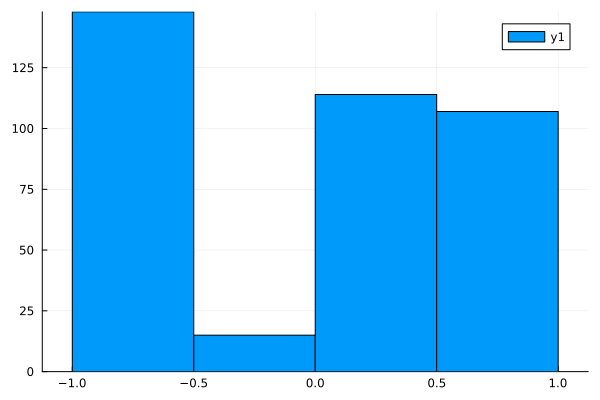

In [29]:
histogram(y_naive |> vec)

In [30]:
using Statistics: std, median, mean

In [31]:
using OneHotArrays

In [32]:
function get_truth(pt, threshold::Real = 0.2)
    return 1 .* (pt .> threshold) .+ 2 .* (pt .< -threshold)
end

get_truth (generic function with 2 methods)

In [33]:
function momentum_to_label(pt, threshold::Real = 0.2)
    y = onehotbatch(get_truth(pt, threshold), (0, 1, 2))
    return y
end

momentum_to_label (generic function with 2 methods)

In [34]:
labels = momentum_to_label(pt)

3×99991 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  1  ⋅  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1
 1  1  ⋅  1  1  ⋅  1  1  ⋅  ⋅  1  1  ⋅     1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  ⋅
 ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  1  1  ⋅  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  1  1  1  1  ⋅  ⋅  ⋅

In [35]:
function loss(x, xl, y, model, ps, st, threshold)
    y_pred, st = model(process_inputs(x, xl), ps, st)
    y = momentum_to_label(y, threshold)
    loss = quadrature_loss(y_pred, y) |> mean
    return loss, st
end

loss (generic function with 1 method)

In [36]:
l0, st0 = @time loss(x, xl, y, model, ps, st, 0.2)

  0.299164 seconds (583.75 k allocations: 41.989 MiB, 4.98% gc time, 99.71% compilation time)


(1.256037613446628, (layer_1 = (running_mean = [0.0, 0.0007275000108405948, 0.009984687648783437, 0.06526031347245444, 0.18840875280750918, 0.2391881285641809, 0.20015500298254196, 0.05920625088224188, 0.008364062624634244, 0.0, 0.0, 0.0, 0.0, 0.07180550185123537], running_var = [0.8999999761581421, 0.9006013163245831, 0.9166694592716942, 1.0714547488537651, 1.6086467878359128, 1.8480822565809447, 1.6426738276027972, 1.0505631442442278, 0.9130537317768708, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 2.9173396135808085], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [37]:
l0

1.256037613446628

In [38]:
function train(model, ps, st, train_loader, threshold::Real = 0.2; kws...)
    args = Args(; kws...) ## Collect options in a struct for convenience

    device = cpu

    @info "Constructing model and starting training"
    ## Construct model
    #model = build_model() |> device

    ## Optimizer
    opt_state = Optimisers.setup(Adam(3e-4), ps)
    losses = []

    ## Training
    for epoch in 1:args.epochs
        #epoch_losses = []
        for (x, xl, y) in train_loader
            (loss_val, st), gs = withgradient(p -> loss(x, xl, y, model, p, st, threshold), ps)
            opt_state, ps = Optimisers.update(opt_state, ps, gs[1]) ## update parameters
            append!(losses, loss_val)
        end
        
    end

    return losses, ps, st
end

train (generic function with 2 methods)

In [39]:
@time loss_history, pst, stt = train(model, ps, st, train_loader, 0.2, epochs = 10)

[ Info: Constructing model and starting training


387.049340 seconds (42.28 M allocations: 135.354 GiB, 4.36% gc time, 4.05% compilation time)


(Any[1.256037613446628, 1.1788250309973414, 1.1333813564090451, 1.0865125179479354, 0.9949240917682861, 0.9158776528507577, 0.9122332989767736, 0.8210545061806857, 0.7967392838988111, 0.8164478858229754  …  0.1612225927316894, 0.1627152089978036, 0.14931923399279115, 0.15802986129956184, 0.1646751136635622, 0.1792100910788724, 0.19720379358842394, 0.18330736611509688, 0.19318085230097198, 0.2669801310692875], (layer_1 = (scale = Float32[0.6996696, 0.98756623, 0.9370418, 0.8544929, 1.0579653, 0.8292135, 1.0864701, 0.97749853, 0.99324274, 0.64844376, 0.49935263, 0.78841305, 0.5350091, 0.32152995], bias = Float32[-0.14599566, -0.029726699, 0.16548963, 0.40393922, 0.1560184, 0.38687953, -0.028025767, 0.27984768, 0.013850455, -0.14078651, -0.054499794, -0.0070200977, -0.10697156, 0.1850256]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.031199537 0.09722662 … -0.04102845 -0.12100395; -0.13137768 0.01957015 … 0.09167865 -0.07488599; … ; 0.12540038 -0.22247334 … -0.057142973 -0.0707

In [40]:
sttf = Lux.testmode(stt)

(layer_1 = (running_mean = [0.03594616161788155, 0.04065939470148213, 0.2436664796816954, 1.0156471076493, 2.3585091340869977, 2.6301745158212135, 1.8952205505395425, 0.6306864595118055, 0.09720460126891782, 0.019270684388906934, 0.011654752692122223, 0.005198475128358864, 0.006348779794351644, 0.15291454619067543], running_var = [0.17845984020323685, 0.10809495006040458, 0.566503800944975, 2.9413779193354155, 9.07403289651072, 7.835651333226607, 7.166495019956767, 1.96909766899202, 0.2683655759503201, 0.06505530708282091, 0.03435994576714579, 0.008197384732891744, 0.03335087394257167, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple())

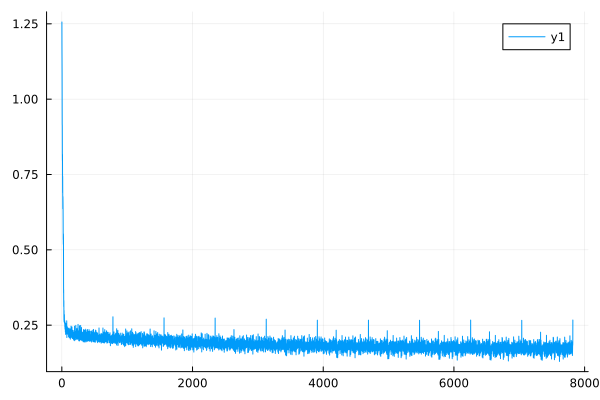

In [41]:
plot(loss_history)

In [42]:
loss(x, xl, y, model, pst, stt, 0.2)[1]

0.17482706881246796

# Check the outputs from the front layers

In [43]:
model_front = Chain(
    BatchNorm(n_in),
    x -> tanh.(x),)

Chain(
    layer_1 = BatchNorm(14, affine=true, track_stats=true),  # 28 parameters, plus 29
    layer_2 = WrappedFunction{:direct_call}(var"#53#54"()),
)         # Total: 28 parameters,
          #        plus 29 states.

In [44]:
ps_front = (layer_1 = pst.layer_1, layer_2 = pst.layer_2)

(layer_1 = (scale = Float32[0.6996696, 0.98756623, 0.9370418, 0.8544929, 1.0579653, 0.8292135, 1.0864701, 0.97749853, 0.99324274, 0.64844376, 0.49935263, 0.78841305, 0.5350091, 0.32152995], bias = Float32[-0.14599566, -0.029726699, 0.16548963, 0.40393922, 0.1560184, 0.38687953, -0.028025767, 0.27984768, 0.013850455, -0.14078651, -0.054499794, -0.0070200977, -0.10697156, 0.1850256]), layer_2 = NamedTuple())

In [45]:
st_front = (layer_1 = stt.layer_1, layer_2 = stt.layer_2)

(layer_1 = (running_mean = [0.03594616161788155, 0.04065939470148213, 0.2436664796816954, 1.0156471076493, 2.3585091340869977, 2.6301745158212135, 1.8952205505395425, 0.6306864595118055, 0.09720460126891782, 0.019270684388906934, 0.011654752692122223, 0.005198475128358864, 0.006348779794351644, 0.15291454619067543], running_var = [0.17845984020323685, 0.10809495006040458, 0.566503800944975, 2.9413779193354155, 9.07403289651072, 7.835651333226607, 7.166495019956767, 1.96909766899202, 0.2683655759503201, 0.06505530708282091, 0.03435994576714579, 0.008197384732891744, 0.03335087394257167, 19.956601029145197], training = Val{true}()), layer_2 = NamedTuple())

In [46]:
ys_f, _ = model_front(process_inputs(x, xl), ps_front, st_front)

([-0.14496714356979926 -0.14496714356979926 … -0.14496714356979926 -0.14496714356979926; -0.12205004714041781 -0.12205004714041781 … -0.12205004714041781 -0.12205004714041781; … ; -0.10656539871834143 -0.10656539871834143 … -0.10656539871834143 -0.10656539871834143; -0.34997692851667156 -0.17638419191232685 … 0.1421063215134183 0.03045240889765156], (layer_1 = (running_mean = [0.032351544599070116, 0.037320954272779, 0.22928451355284774, 0.9793426861419104, 2.3110669172545673, 2.606345130095026, 1.905853453282551, 0.6268240494061298, 0.09584820144912198, 0.017343615490567323, 0.010489277145039043, 0.0046786274915816715, 0.005713901663549774, 0.2094285897770764], running_var = [0.16061385192809902, 0.09788679264362066, 0.5265228904575264, 2.8186948299695826, 8.875276202195616, 8.000168293510264, 7.19251919854319, 1.922751023231957, 0.2545827675756829, 0.058549774823499434, 0.030923950371226264, 0.007377646064161688, 0.030015785753167705, 19.978280087850898], training = Val{true}()), lay

In [47]:
size(ys_f)

(14, 128)

In [48]:
xi = process_inputs(x, xl);

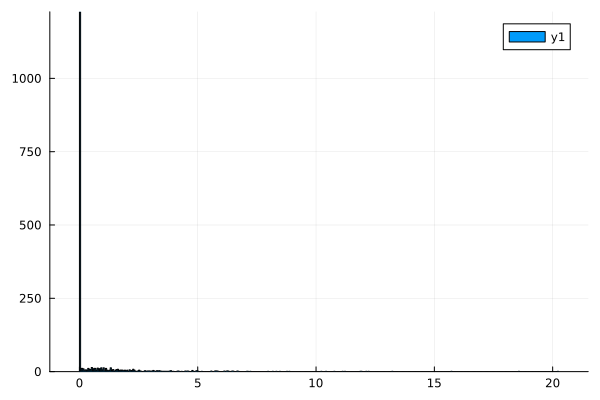

In [49]:
histogram(vec(xi[1:13,:]))

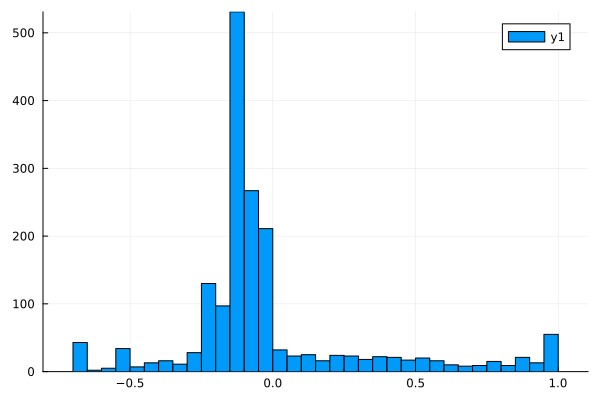

In [50]:
histogram(ys_f |> vec)

In [51]:
yt, _ = model(process_inputs(x, xl), pst, sttf)

([0.01604356546150391 0.01735386574931546 … 0.012409586574165469 0.012764896330003092; 0.44849967330861246 0.2802195311802917 … 0.1935845545354345 0.2037650391596087; 0.057151396830778564 0.2105105364626943 … 0.3367744018385197 0.20772415012884596], (layer_1 = (running_mean = [0.03594616161788155, 0.04065939470148213, 0.2436664796816954, 1.0156471076493, 2.3585091340869977, 2.6301745158212135, 1.8952205505395425, 0.6306864595118055, 0.09720460126891782, 0.019270684388906934, 0.011654752692122223, 0.005198475128358864, 0.006348779794351644, 0.15291454619067543], running_var = [0.17845984020323685, 0.10809495006040458, 0.566503800944975, 2.9413779193354155, 9.07403289651072, 7.835651333226607, 7.166495019956767, 1.96909766899202, 0.2683655759503201, 0.06505530708282091, 0.03435994576714579, 0.008197384732891744, 0.03335087394257167, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

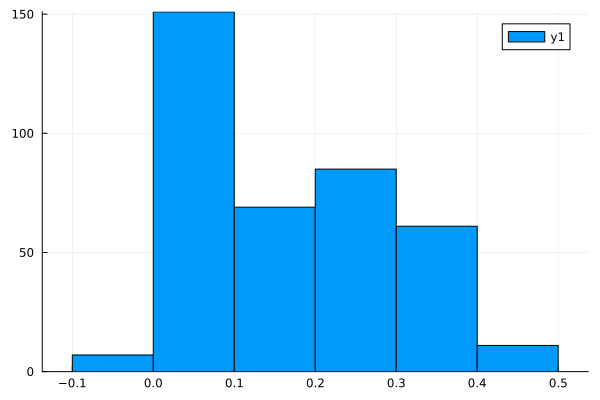

In [52]:
histogram(yt |> vec)

# Calculate the Test Loss

In [53]:
function decay_and_fire(q0::Vector{<:Real}, lambda::Real, k::Real)
    t = log(k .* q0) ./ (-1 * lambda)
    return t
end

decay_and_fire (generic function with 1 method)

In [54]:
decay_and_fire

decay_and_fire (generic function with 1 method)

In [55]:
xts, xlts, yts = first(test_loader)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [56]:
function accuracy(x, xl, y, model, ps, st, threshold::Real)
    y_truth = get_truth(y, threshold)
    y_pred, _ = model(process_inputs(x, xl), ps, st)
    #predict & correct for zero indexing
    y_labels = predict_quadrature(y_pred) .- 1
    right = sum(y_truth .== y_labels)
    return right
end

accuracy (generic function with 1 method)

In [57]:
yth, _ = model(process_inputs(q_test[:,:,:,1:10000], ylocal_test[1:10000]), pst, stt)

([0.018559030662758914 0.015761414140423664 … 0.018645918077321674 0.018071666507376752; 0.027288261935680735 0.0015760273078456299 … 0.03631770711642651 0.2963594770330738; 0.40246888229863126 0.3773474314956636 … 0.3446980910454188 0.1567169619440884], (layer_1 = (running_mean = [0.034631380633042316, 0.03982174631004372, 0.2451869742898128, 1.0233261014973147, 2.359646587578462, 2.634903269920575, 1.89858549437425, 0.6316620606782218, 0.09877864299278898, 0.019815863527406687, 0.011903677166115244, 0.005394331502246492, 0.006217401671052509, 0.13936485193179532], running_var = [0.17184187351968377, 0.1045715148436045, 0.5713877119339248, 2.990126611337082, 9.045938320572658, 7.853287653827764, 7.229449784592336, 1.967455892285519, 0.27188567460226626, 0.06821195170421673, 0.036241541131131934, 0.008975805015312654, 0.031245482471461722, 20.015114414752457], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [58]:
accuracy(q_test[:,:,:,1:10000], ylocal_test[1:10000], pt_test[1:10000], model, pst, stt, 0.2)

6929

In [59]:
using LinearAlgebra: diag

In [60]:
roc = tpr_fpr(yth, pt_test[1:10000])

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [61]:
roc_fn = linear_interpolation(average_duplicate_knots(roc[2], roc[1])...)

20-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Throw()) with element type Float64:
 0.0
 0.0
 0.0005
 0.006
 0.0326
 0.1058
 0.2466
 0.4354
 0.6228
 0.7688
 0.8604
 0.9085
 0.9308
 0.9943
 0.9974
 0.9984
 0.9992
 0.9999
 1.0
 1.0

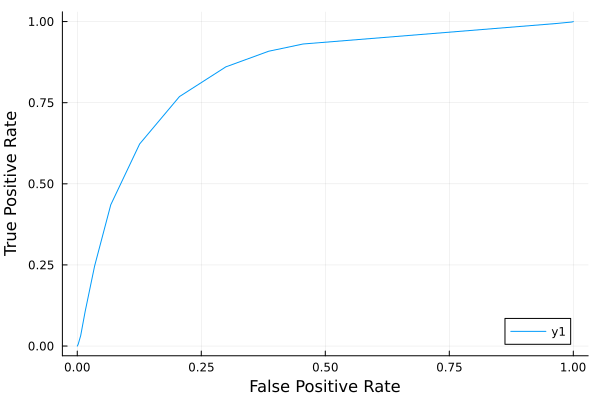

In [62]:
plot(roc[2], roc[1])
xlabel!("False Positive Rate")
ylabel!("True Positive Rate")

In [63]:
auc, _ = quadgk(roc_fn, 0.0, 1.0)

(0.8436385723724106, 1.1933848808273365e-8)

# Build a Spiking Version

In [64]:
sa = SpikingArgs()
repeats = 20

20

In [78]:
mf_spk = Chain(
    BatchNorm(n_in),
    x -> tanh.(x),
    MakeSpiking(sa, repeats),
    PhasorDense(n_in => 128),)

Chain(
    layer_1 = BatchNorm(14, affine=true, track_stats=true),  # 28 parameters, plus 29
    layer_2 = WrappedFunction{:direct_call}(var"#57#58"()),
    layer_3 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 20, (0.0, 20.0), 0.0),
    layer_4 = PhasorDense((14, 128)),   # 1_920 parameters
)         # Total: 1_948 parameters,
          #        plus 29 states.

In [65]:
model_spk = Chain(
    BatchNorm(n_in),
    x -> tanh.(x),
    MakeSpiking(sa, repeats),
    PhasorDense(n_in => 128),
    PhasorDense(128 => 3) 
)

Chain(
    layer_1 = BatchNorm(14, affine=true, track_stats=true),  # 28 parameters, plus 29
    layer_2 = WrappedFunction{:direct_call}(var"#55#56"()),
    layer_3 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 20, (0.0, 20.0), 0.0),
    layer_4 = PhasorDense((14, 128)),   # 1_920 parameters
    layer_5 = PhasorDense((128, 3)),    # 387 parameters
)         # Total: 2_335 parameters,
          #        plus 29 states.

In [66]:
function convert_pmlp_params(pmlp_ps)
    # Add a dummy layer of params for the make_spiking layer
    spk_ps = (layer_1 = pmlp_ps.layer_1, 
            layer_2 = pmlp_ps.layer_2,
            layer_3 = NamedTuple(),
            layer_4 = pmlp_ps.layer_3,
            layer_5 = pmlp_ps.layer_4)
    return spk_ps
end      

convert_pmlp_params (generic function with 1 method)

In [67]:
pst_spk = convert_pmlp_params(pst)
sttf_spk = convert_pmlp_params(sttf)

(layer_1 = (running_mean = [0.03594616161788155, 0.04065939470148213, 0.2436664796816954, 1.0156471076493, 2.3585091340869977, 2.6301745158212135, 1.8952205505395425, 0.6306864595118055, 0.09720460126891782, 0.019270684388906934, 0.011654752692122223, 0.005198475128358864, 0.006348779794351644, 0.15291454619067543], running_var = [0.17845984020323685, 0.10809495006040458, 0.566503800944975, 2.9413779193354155, 9.07403289651072, 7.835651333226607, 7.166495019956767, 1.96909766899202, 0.2683655759503201, 0.06505530708282091, 0.03435994576714579, 0.008197384732891744, 0.03335087394257167, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple())

In [68]:
yth_spk, _ = model_spk(process_inputs(q_test[:,:,:,1:10000], ylocal_test[1:10000]), pst_spk, sttf_spk)

(SpikingCall(Spike Train: (3, 10000) with 599999 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 20.0)), (layer_1 = (running_mean = [0.03594616161788155, 0.04065939470148213, 0.2436664796816954, 1.0156471076493, 2.3585091340869977, 2.6301745158212135, 1.8952205505395425, 0.6306864595118055, 0.09720460126891782, 0.019270684388906934, 0.011654752692122223, 0.005198475128358864, 0.006348779794351644, 0.15291454619067543], running_var = [0.17845984020323685, 0.10809495006040458, 0.566503800944975, 2.9413779193354155, 9.07403289651072, 7.835651333226607, 7.166495019956767, 1.96909766899202, 0.2683655759503201, 0.06505530708282091, 0.03435994576714579, 0.008197384732891744, 0.03335087394257167, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [69]:
yth_spk2 = train_to_phase(yth_spk);

In [70]:
size(yth_spk2)

(20, 3, 10000)

In [71]:
size(yth)

(3, 10000)

In [72]:
cycle_correlation(yth, yth_spk2)

20-element Vector{Float64}:
 0.46871151976250713
 0.949746487553367
 0.9721444777400331
 0.9825648386658853
 0.9876546550257302
 0.9902221454332092
 0.9915285337268553
 0.9921726238498935
 0.9924625035508642
 0.9925580467044162
 0.9925474762660028
 0.9924805714285996
 0.9923857422486296
 0.9922793267182265
 0.9921708036234634
 0.9920658931815746
 0.9919670409726451
 0.9918755780480909
 0.9917920942960347
 0.29930492987786267

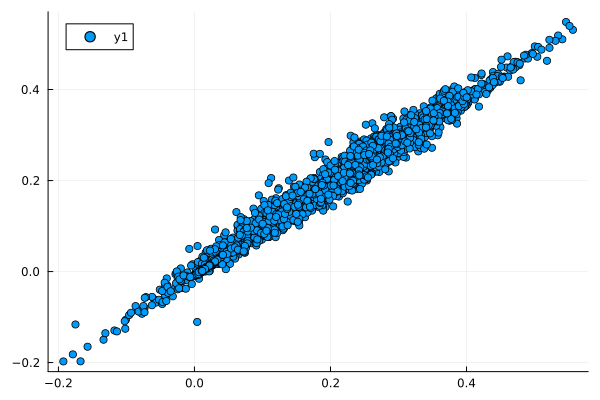

In [73]:
scatter(vec(yth[:,1:1000]), vec(yth_spk2[end-1,:,1:1000]))

In [74]:
roc_spk = tpr_fpr(yth_spk2[end-1,:,:], pt_test[1:10000])

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

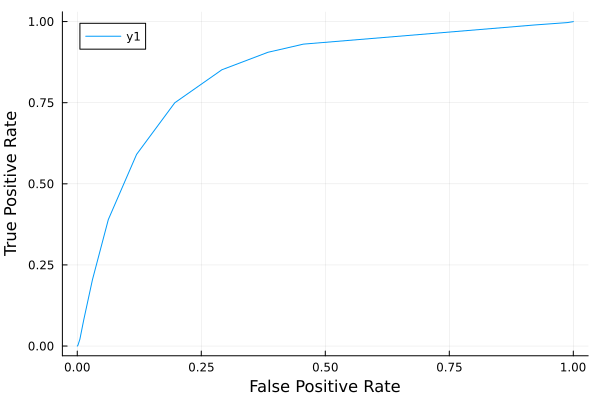

In [75]:
plot(roc_spk[2], roc_spk[1])
xlabel!("False Positive Rate")
ylabel!("True Positive Rate")

In [76]:
roc_spk_fn = linear_interpolation(average_duplicate_knots(roc_spk[2], roc_spk[1])...)

19-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Throw()) with element type Float64:
 0.0
 0.0
 0.0025
 0.0212
 0.0803
 0.2044
 0.3898
 0.5907
 0.7497
 0.8514
 0.9052
 0.9304
 0.9894
 0.9968
 0.9986
 0.9993
 0.9999
 0.99995
 1.0

In [77]:
quadgk(roc_spk_fn, 0.0, 1.0)

(0.8401568033318377, 1.2436516216914959e-8)